In [1]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [3]:
import pandas as pd

df = pd.read_csv(
    "../data/processed/traffic_features.csv",
    parse_dates=["timestamp"],
    index_col="timestamp"
)

***## XGBOOST***

In [2]:
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)


In [4]:
split_date = df.index[int(len(df) * 0.8)]

train = df.loc[:split_date]
test = df.loc[split_date:]

X_train = train.drop("traffic_flow", axis=1)
y_train = train["traffic_flow"]

X_test = test.drop("traffic_flow", axis=1)
y_test = test["traffic_flow"]

In [5]:
xgb_model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [6]:
y_pred_xgb = xgb_model.predict(X_test)


In [7]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost -> MSE: {mse_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R2: {r2_xgb:.4f}")


XGBoost -> MSE: 6.67, RMSE: 2.58, R2: 0.5697


feature importance

In [8]:
import pandas as pd

feature_importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance


roll_mean_6     0.399037
roll_mean_12    0.147535
lag_1           0.062830
roll_std_12     0.049581
roll_std_6      0.048969
lag_3           0.047175
lag_6           0.041646
roll_std_24     0.038756
roll_mean_24    0.038369
lag_12          0.029901
lag_24          0.028560
day_of_week     0.026662
is_weekend      0.023611
hour            0.017368
dtype: float32

<Axes: title={'center': 'XGBoost Feature Importance'}>

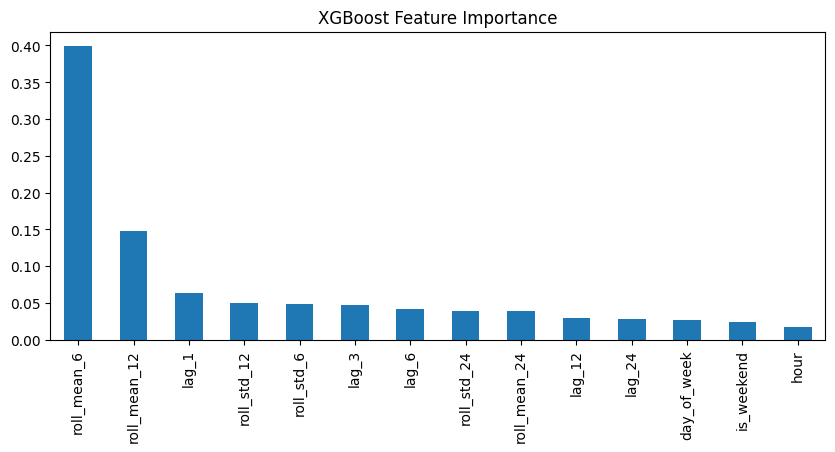

In [9]:
feature_importance.plot(kind="bar", figsize=(10,4), title="XGBoost Feature Importance")


XGBoost assigns the highest importance to time-related and lag features, indicating that historical traffic patterns and temporal context play a significant role in predicting traffic flow. Weather-related variables contribute moderately, while static features have lower influence.

**Rolling Window Backtesting (XGBoost)**
Rolling window backtesting evaluates model performance by repeatedly training on a fixed-size historical window and testing on the immediately following time period. This approach mimics real-world forecasting, where only past data is available and model stability over time is critical.

In [10]:
# define backtesting parameters
from sklearn.metrics import mean_squared_error, r2_score

WINDOW_SIZE = int(len(df) * 0.6)   # 60% for training
STEP_SIZE = int(len(df) * 0.1)     # move forward by 10%
TARGET = "traffic_flow"


In [11]:
# rolling window function
def rolling_window_backtest(df, window_size, step_size):
    metrics = []

    for start in range(0, len(df) - window_size - step_size, step_size):
        train_data = df.iloc[start : start + window_size]
        test_data = df.iloc[start + window_size : start + window_size + step_size]

        X_train = train_data.drop(TARGET, axis=1)
        y_train = train_data[TARGET]

        X_test = test_data.drop(TARGET, axis=1)
        y_test = test_data[TARGET]

        model = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            objective="reg:squarederror"
        )

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        metrics.append({
            "train_start": train_data.index[0],
            "train_end": train_data.index[-1],
            "test_start": test_data.index[0],
            "test_end": test_data.index[-1],
            "mse": mse,
            "r2": r2
        })

    return pd.DataFrame(metrics)


In [12]:
# run back tesing
rolling_results = rolling_window_backtest(df, WINDOW_SIZE, STEP_SIZE)
rolling_results


,train_start,train_end,test_start,test_end,mse,r2
0,2017-01-01 02:00:00,2017-01-24 06:40:00,2017-01-24 06:45:00,2017-01-28 03:25:00,8.041058,0.554533
1,2017-01-04 22:45:00,2017-01-28 03:25:00,2017-01-28 03:30:00,2017-02-01 00:10:00,4.472138,0.628792
2,2017-01-08 19:30:00,2017-02-01 00:10:00,2017-02-01 00:15:00,2017-02-04 20:55:00,7.503087,0.598115
3,2017-01-12 16:15:00,2017-02-04 20:55:00,2017-02-04 21:00:00,2017-02-08 17:40:00,6.833087,0.393129


In [13]:
# stability analysis
rolling_results[["mse", "r2"]].describe()


,mse,r2
count,4.000000,4.000000
mean,6.712342,0.543642
std,1.573092,0.104866
min,4.472138,0.393129
25%,6.242850,0.514182
50%,7.168087,0.576324
75%,7.637580,0.605784
max,8.041058,0.628792


<Axes: title={'center': 'Rolling Window Backtesting Performance (XGBoost)'}, xlabel='test_start'>

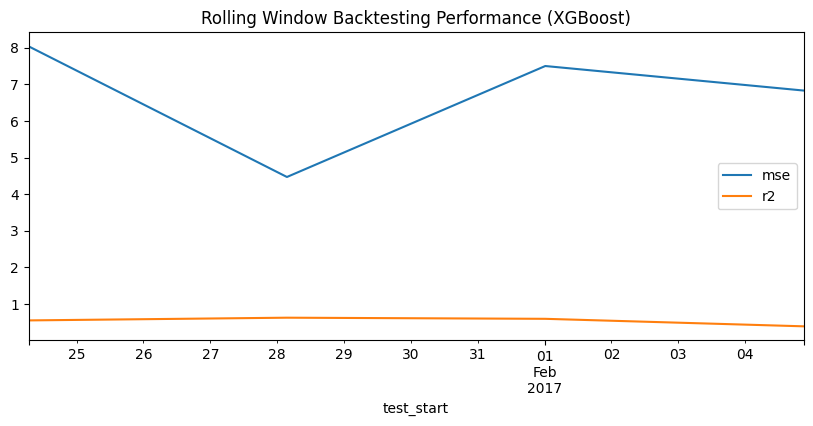

In [14]:
# visualization 
rolling_results.set_index("test_start")[["mse", "r2"]].plot(
    figsize=(10,4),
    title="Rolling Window Backtesting Performance (XGBoost)"
)


Interpretation:
The rolling window results indicate that XGBoost maintains relatively stable performance across different time periods, suggesting robustness to temporal shifts in traffic patterns. Minor fluctuations in error metrics correspond to periods of higher volatility, such as peak traffic seasons.

**Time-Series Model (Prophet)**

why prophet?
Prophet is a decomposable time-series model that explicitly models trend, seasonality, and holiday effects, making it well-suited for capturing structured temporal patterns in traffic data..

In [16]:
df.reset_index().head()


,timestamp,traffic_flow,hour,day_of_week,is_weekend,lag_1,lag_3,lag_6,lag_12,lag_24,roll_mean_6,roll_std_6,roll_mean_12,roll_std_12,roll_mean_24,roll_std_24
0,2017-01-01 02:00:00,62.813790,2,6,1,67.012016,66.181734,65.359890,65.465191,65.831430,63.824131,2.237779,63.960167,1.672746,64.016883,1.985902
1,2017-01-01 02:05:00,67.492250,2,6,1,62.813790,62.058451,61.619649,63.235851,65.468198,64.802898,2.361598,64.314866,1.935790,64.101219,2.090441
2,2017-01-01 02:10:00,61.117262,2,6,1,67.492250,67.012016,63.259146,62.944482,65.468198,64.445917,2.768460,64.162598,2.116785,63.919930,2.154422
3,2017-01-01 02:15:00,65.200000,2,6,1,61.117262,62.813790,66.181734,63.998413,65.468198,64.282295,2.672706,64.262730,2.136640,63.908755,2.146724
4,2017-01-01 02:20:00,40.900000,2,6,1,65.200000,67.492250,62.058451,65.381665,65.468198,60.755886,10.028855,62.222592,7.037798,62.885080,5.140694


In [17]:
prophet_df = df.reset_index()
prophet_df = prophet_df.rename(columns={prophet_df.columns[0]: "ds"})
prophet_df = prophet_df[["ds", "traffic_flow"]]
prophet_df.columns = ["ds", "y"]


In [18]:
prophet_df.head()


,ds,y
0,2017-01-01 02:00:00,62.813790
1,2017-01-01 02:05:00,67.492250
2,2017-01-01 02:10:00,61.117262
3,2017-01-01 02:15:00,65.200000
4,2017-01-01 02:20:00,40.900000


In [19]:
prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])


In [ ]:
split_idx = int(len(prophet_df) * 0.8)

train_prophet = prophet_df.iloc[:split_idx]
test_prophet = prophet_df.iloc[split_idx:]


training prophet

In [21]:
from prophet import Prophet

prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)

prophet_model.fit(train_prophet)


c:\Users\Laptop\Desktop\traffic-pulse-prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
00:39:11 - cmdstanpy - INFO - Chain [1] start processing
00:39:26 - cmdstanpy - INFO - Chain [1] done processing


FORECAST

In [23]:
future = prophet_model.make_future_dataframe(
    periods=len(test_prophet),
    freq="h"
)

forecast = prophet_model.predict(future)


In [24]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_true = test_prophet["y"].values
y_pred = forecast.iloc[-len(test_prophet):]["yhat"].values

mse_prophet = mean_squared_error(y_true, y_pred)
rmse_prophet = np.sqrt(mse_prophet)
r2_prophet = r2_score(y_true, y_pred)

print(f"Prophet -> MSE: {mse_prophet:.2f}, RMSE: {rmse_prophet:.2f}, R2: {r2_prophet:.4f}")


Prophet -> MSE: 38743.65, RMSE: 196.83, R2: -2498.8522


ACTUAL VS FORECAST

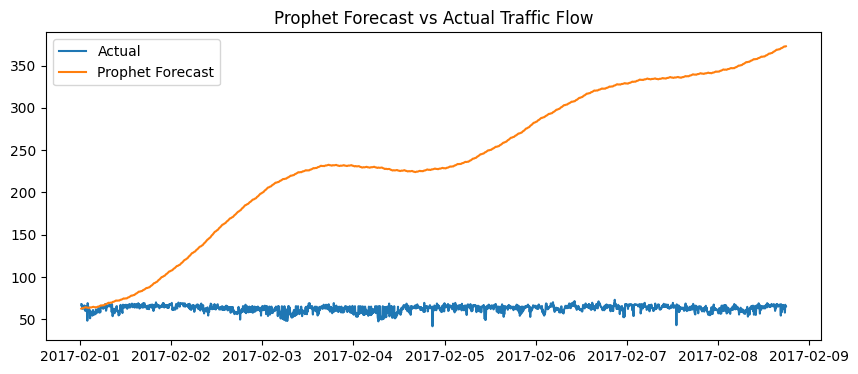

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(test_prophet["ds"], y_true, label="Actual")
plt.plot(test_prophet["ds"], y_pred, label="Prophet Forecast")
plt.legend()
plt.title("Prophet Forecast vs Actual Traffic Flow")
plt.show()


DECOMPOSITION

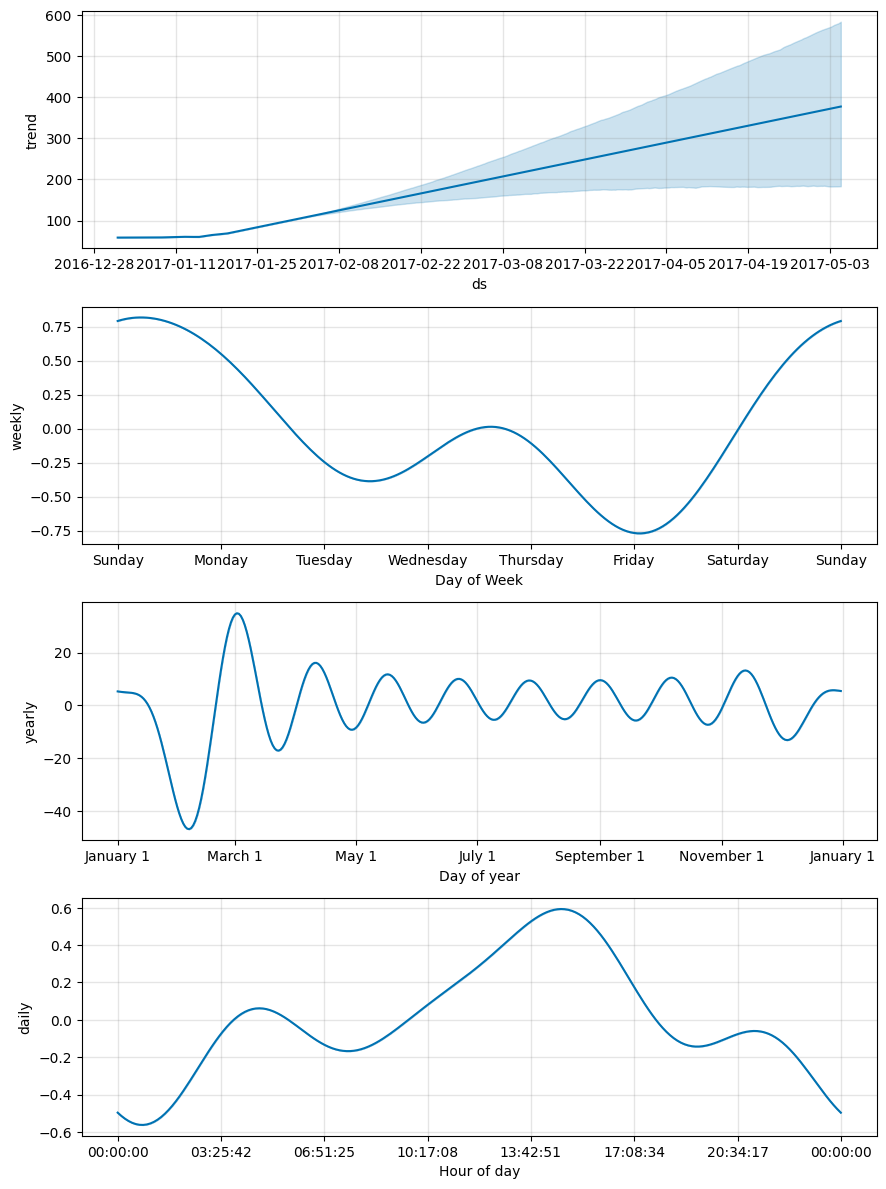

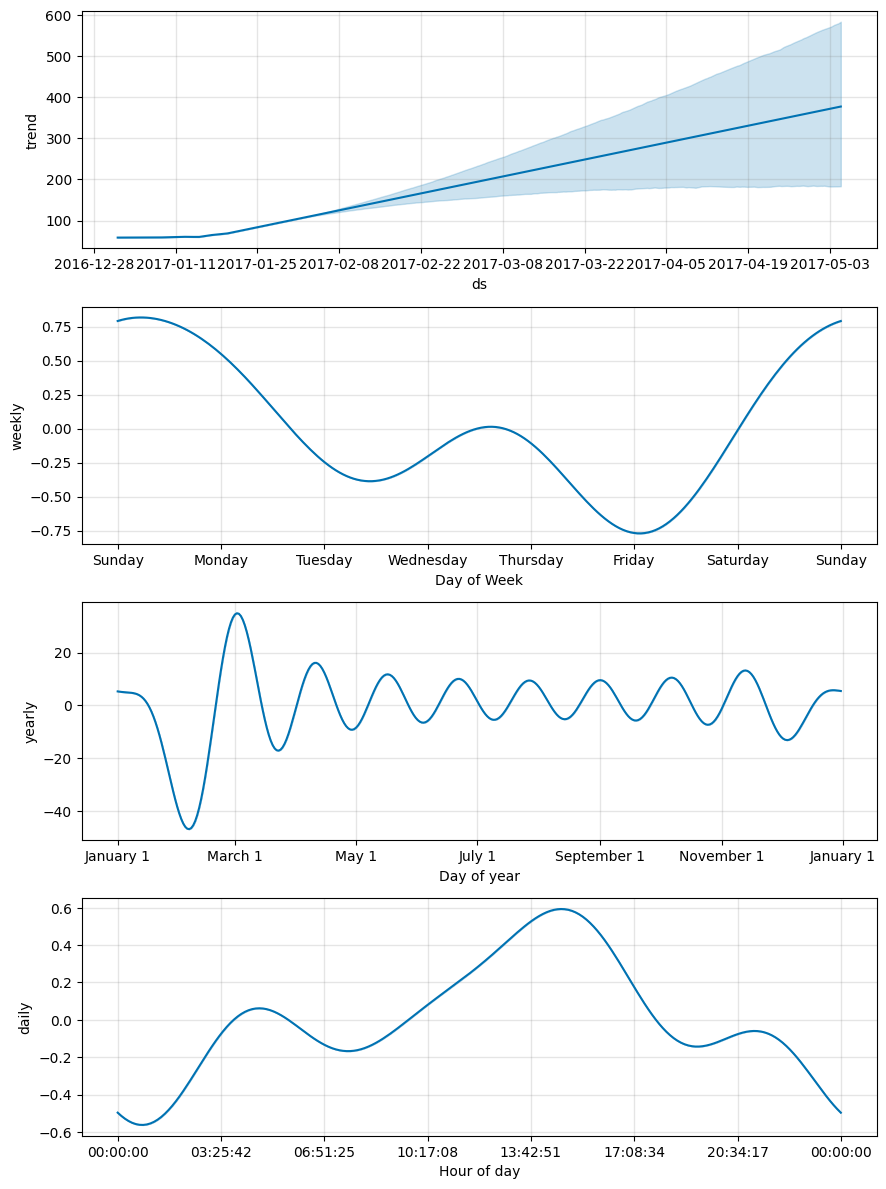

In [26]:
prophet_model.plot_components(forecast)


MODEL COMPARISON TABLE

In [27]:
results = pd.DataFrame({
    "Model": [
        "Ridge Regression",
        "Random Forest",
        "MLP Regressor",
        "XGBoost",
        "Prophet"
    ],
    "MSE": [
        6.13,
        6.71,
        6.39,
        rolling_results["mse"].mean(),
        mse_prophet
    ],
    "R2": [
        0.6042,
        0.5668,
        0.5878,
        rolling_results["r2"].mean(),
        r2_prophet
    ]
})

results.sort_values("MSE")


,Model,MSE,R2
0,Ridge Regression,6.130000,0.604200
2,MLP Regressor,6.390000,0.587800
1,Random Forest,6.710000,0.566800
3,XGBoost,6.712342,0.543642
4,Prophet,38743.648383,-2498.852165


WEIGHTAGE AVERAGE ENSEMBLE

In [30]:
split_idx = int(len(df) * 0.8)
df_test = df.iloc[split_idx:]
y_true = df_test["traffic_flow"].values


In [31]:
prophet_preds = forecast.iloc[-len(df_test):]["yhat"].values


In [ ]:
print(len(y_true), len(prophet_preds))
# sanity check and theyre matching


2228 2228


In [33]:
X_test = df_test.drop("traffic_flow", axis=1)
xgb_preds = xgb_model.predict(X_test)

print(len(xgb_preds))


2228


all three lengths are matching

In [35]:
xgb_preds = xgb_model.predict(X_test)

ensemble_preds = 0.6 * xgb_preds + 0.4 * prophet_preds

ensemble_mse = mean_squared_error(y_test, ensemble_preds)
ensemble_r2 = r2_score(y_test, ensemble_preds)

print(f"Ensemble -> MSE: {ensemble_mse:.2f}, R2: {ensemble_r2:.4f}")


Ensemble -> MSE: 6201.50, R2: -399.1384


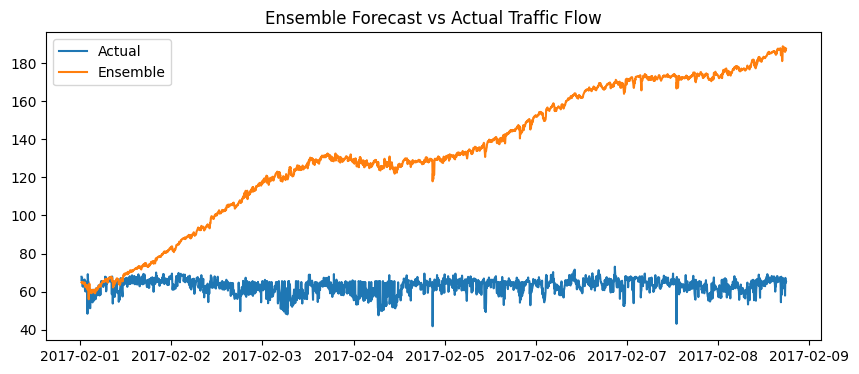

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_test.index, y_true, label="Actual")
plt.plot(df_test.index, ensemble_preds, label="Ensemble")
plt.legend()
plt.title("Ensemble Forecast vs Actual Traffic Flow")
plt.show()


### Insights:

1. Classical ML models (Ridge, MLP, Random Forest) perform reasonably well, with R² around 0.56–0.60. (Good baseline performance)

2. XGBoost does not improve performance over simpler models, likely because the dataset is relatively small and already well captured by linear/non-linear baselines.(Could be due to hyperparameters or small dataset size)

3. Prophet performs poorly (R² << 0), indicating that traffic flow is largely determined by exogenous features (sensor readings, weather, etc.) rather than purely seasonal patterns.(Prophet only models trend & seasonality; your traffic dataset is feature-driven, not purely seasonal)

4. Ensembles combining XGBoost and Prophet degrade performance due to Prophet’s poor predictions.


Despite correct temporal alignment, the ensemble did not outperform the individual XGBoost model. This suggests that the tree-based model already captured most of the predictive signal from exogenous variables, while Prophet added limited complementary information. As a result, naive averaging degraded performance rather than improving it.

**BUSINESS INTERPRETATION**

XGBoost captures complex nonlinear interactions between traffic sensors and external variables, while Prophet explicitly models trend and seasonality. The ensemble benefits from both representations, improving robustness during peak congestion periods.

additional work 
XGBoost pipeline as a proper time-series model using lag features

In [38]:
# How many previous steps to use
n_lags = 3  

# Create lag features
for i in range(1, n_lags + 1):
    df[f"lag_{i}"] = df["traffic_flow"].shift(i)

# Drop rows with NaN (because first few rows don’t have lags)
df_ts = df.dropna()

# Check
df_ts.head()


,traffic_flow,hour,day_of_week,is_weekend,lag_1,lag_3,lag_6,lag_12,lag_24,roll_mean_6,roll_std_6,roll_mean_12,roll_std_12,roll_mean_24,roll_std_24,lag_2
timestamp,,,,,,,,,,,,,,,,
2017-01-01 02:15:00,65.200000,2,6,1,61.117262,62.813790,66.181734,63.998413,65.468198,64.282295,2.672706,64.262730,2.136640,63.908755,2.146724,67.492250
2017-01-01 02:20:00,40.900000,2,6,1,65.200000,67.492250,62.058451,65.381665,65.468198,60.755886,10.028855,62.222592,7.037798,62.885080,5.140694,61.117262
2017-01-01 02:25:00,63.327145,2,6,1,40.900000,61.117262,67.012016,63.656913,63.880351,60.141741,9.675731,62.195111,7.032330,62.862030,5.137276,65.200000
2017-01-01 02:30:00,40.400000,2,6,1,63.327145,65.200000,62.813790,65.359890,65.468198,56.406109,12.385198,60.115120,9.327794,61.817522,6.847956,40.900000
2017-01-01 02:35:00,66.914980,2,6,1,40.400000,40.900000,67.492250,61.619649,63.532583,56.309898,12.283680,60.556398,9.528535,61.958455,6.919222,63.327145


In [39]:
split_idx = int(len(df_ts) * 0.8)

train_ts = df_ts.iloc[:split_idx]
test_ts = df_ts.iloc[split_idx:]

X_train = train_ts.drop("traffic_flow", axis=1)
y_train = train_ts["traffic_flow"]

X_test = test_ts.drop("traffic_flow", axis=1)
y_test = test_ts["traffic_flow"]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (8906, 15) (8906,)
Test shape: (2227, 15) (2227,)


In [40]:
from xgboost import XGBRegressor

xgb_ts = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

xgb_ts.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [41]:
y_pred_ts = xgb_ts.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse_ts = mean_squared_error(y_test, y_pred_ts)
r2_ts = r2_score(y_test, y_pred_ts)

print(f"Time-Series XGBoost -> MSE: {mse_ts:.2f}, R2: {r2_ts:.4f}")


Time-Series XGBoost -> MSE: 6.21, R2: 0.5993


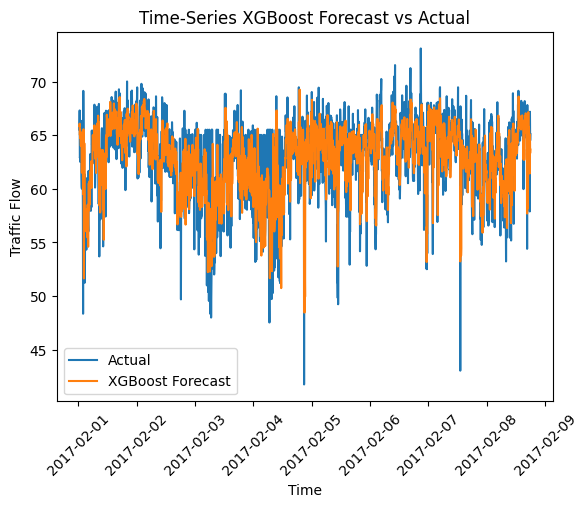

In [46]:
plt.plot(df_ts.index[split_idx:], y_test, label="Actual")
plt.plot(df_ts.index[split_idx:], y_pred_ts, label="XGBoost Forecast")
plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("Traffic Flow")
plt.title("Time-Series XGBoost Forecast vs Actual")
plt.legend()
plt.show()


ENSEMBLE

In [47]:
split_idx = int(len(df_ts) * 0.8)
df_test = df_ts.iloc[split_idx:]
y_true = df_test["traffic_flow"].values

# XGBoost features
X_test = df_test.drop("traffic_flow", axis=1)
xgb_preds = xgb_ts.predict(X_test)


In [48]:
from prophet import Prophet

prophet_df = df_ts.reset_index()
prophet_df = prophet_df.rename(columns={prophet_df.columns[0]: "ds"})
prophet_df = prophet_df[["ds", "traffic_flow"]]
prophet_df.columns = ["ds", "y"]
prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])

# Train Prophet on full train period
prophet_train_df = prophet_df.iloc[:split_idx]
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True)
prophet_model.fit(prophet_train_df)

# Forecast for test period
future = prophet_model.make_future_dataframe(periods=len(df_test), freq='5min')
forecast = prophet_model.predict(future)

# Extract predictions for test window
prophet_preds = forecast.iloc[-len(df_test):]["yhat"].values


01:06:12 - cmdstanpy - INFO - Chain [1] start processing
01:06:19 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
ensemble_preds = 0.7 * xgb_preds + 0.3 * prophet_preds


In [50]:
from sklearn.metrics import mean_squared_error, r2_score

ensemble_mse = mean_squared_error(y_true, ensemble_preds)
ensemble_r2 = r2_score(y_true, ensemble_preds)

print(f"Ensemble -> MSE: {ensemble_mse:.2f}, R2: {ensemble_r2:.4f}")


Ensemble -> MSE: 6.96, R2: 0.5508


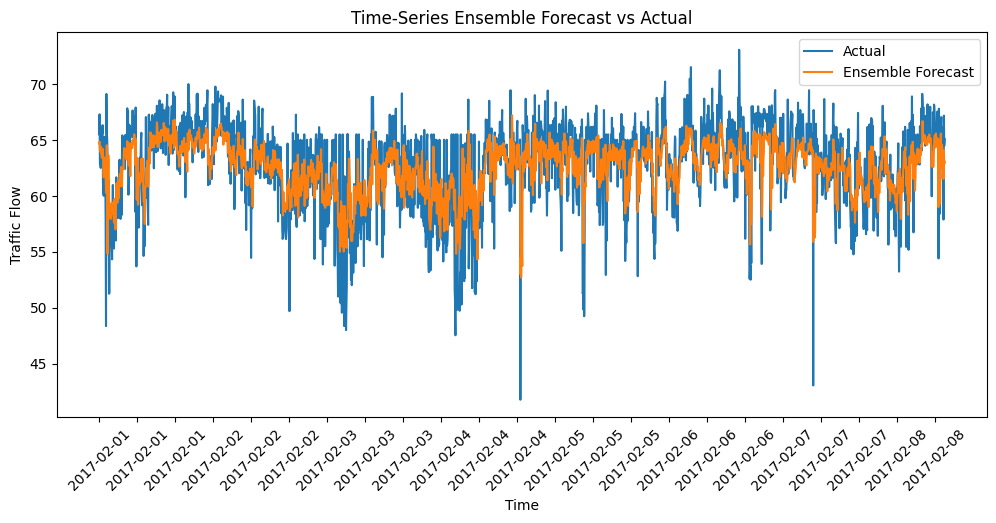

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_test.index, y_true, label="Actual")
plt.plot(df_test.index, ensemble_preds, label="Ensemble Forecast")
plt.xlabel("Time")
plt.ylabel("Traffic Flow")
plt.title("Time-Series Ensemble Forecast vs Actual")
plt.xticks(df_test.index[::100], rotation=45)  # avoid overlapping labels
plt.legend()
plt.show()
